Seminar Stochastik in Aktion, Johannes Schade

# Walker's Trick (Alias Method)

First, we import the necessary libraries and methods:

In [2]:
import numpy as np
from math import exp, factorial
import matplotlib.pyplot as plt

Define the Poisson probability function 
$p_\lambda(k) = \lambda^k \frac{e^{-\lambda}}{k!}$:

In [3]:
def poisson (k, lam=1):
    return lam**k * exp(-lam)/factorial(k)

In [4]:
# Set cut-off value for infinite discrete probability distribution:
n=20

# Store first n-2 values
d = [poisson(i, lam = 4) for i in range(n-1)]
# append last value s.t. sum(p)=1 to achieve proper probablity distribution
d.append(1-sum(d))

print(f'd={d}')

d=[0.01831563888873418, 0.07326255555493671, 0.14652511110987343, 0.19536681481316456, 0.19536681481316456, 0.15629345185053165, 0.1041956345670211, 0.059540362609726345, 0.029770181304863173, 0.013231191691050298, 0.0052924766764201195, 0.0019245369732436798, 0.00064151232441456, 0.00019738840751217228, 5.6396687860620656e-05, 1.5039116762832175e-05, 3.759779190708044e-06, 8.846539272254221e-07, 1.9658976160564933e-07, 5.158784055492305e-08]


Plot for plausibility:

<BarContainer object of 20 artists>

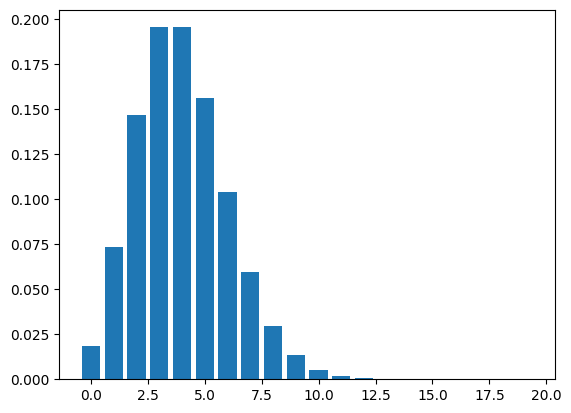

In [5]:
plt.bar([i for i in range(len(d))], d)

Create alias table (in form of the two rows `probs` and `alias`')

In [6]:
def alias_table(d):
    """
    :param list d: list of probabilities of probability distribution
    :return probs, alias: alias table for Walker's alias method
    """
    # convert to numpy.array for convenient methods
    d = np.array(d)
    n_d = n * d

    # initialize probs-alias-table
    probs = np.array(n * [None])
    alias = np.zeros(n, dtype='int32')

    for i in range(n_d.size - 1):
        # choose index (col) with area left
        lesser = np.where(n_d < 1)[0][0]  
        # choose index (col) with area overshoot
        greater = np.where(n_d >= 1)[0][0]
        # save save Pr(l) to probs[l]
        probs[lesser] = n_d[lesser]
        # save index of overshoot probability to alias[l]
        alias[lesser] = greater
        # reduce n_d[g] by probability mass distributed to alias[l]
        n_d[greater] = n_d[greater] - (1 - n_d[lesser])
        # remove probability mass used in probs[l]
        n_d[lesser] = None

    # take care of last probability left over
    probs[np.where(probs == None)[0][0]] = 1
    
    return probs, alias

With `probs` and `alias` we can sample by using only the $\mathcal{U}_{[0,1)}$ generator `numpy.random.uniform(0,1)`:


In [7]:
def alias_sample(probs, alias):
    """
    :param probs: probability row of alias table
    :param alias: alias row of alias table
    :return:
    """
    omega = n*np.random.uniform(0,1) # cont. Uniform distribution
    rrow = int(omega) # discrete Uniform distribution
    rcol = omega - rrow

    if rcol < probs[rrow]: return rrow
    else: return alias[rrow]

By composing the functions `alias_table` and `alias_sample` we obtain an implementation of the alias method:

In [8]:
def alias_method(d):
    """
    :param p: list of probabilities of probability distribution
    :return: sample from probability distribution
    """
    probs, alias = alias_table(d)
    return alias_sample(probs, alias)

Checking sample mean and sample variance for plausibility:

In [9]:
# initialize sample array:
sample = []
for i in range(10**4):
    sample.append(alias_method(d))

# calculate mean and variance
print(f'mean = {np.mean(sample)}, variance = {np.var(sample)}')

mean = 4.0382, variance = 3.9965407600000007


# Application to the epidemic

We assume probabilites $r_i$ of transmitting a disease on te $i$-th day of infection:

In [10]:
r = np.array([0, 0, 0, 0, 0.1, 0.3, 0.4, 0.4, 0.2, 0])

For every day $i$, we sample several $p(i)$ with $\lambda = 4$ for the number of contacts:

In [11]:
n_samples=10**3
c = np.zeros((n_samples, 10))
for i in range (n_samples):
    for j in range(10):
        c[i,j] = alias_method(d)

Calculate $\sum_{i=0}^{9} r_iX_i = \mathbf{r}^\intercal \mathbf{X}$ for every of the "indivdual samples":

In [12]:
for i in range(10):
    print(f'Average number of people infected by individual {i}: {np.dot(r, c[i])}')

Average number of people infected by individual 0: 6.3
Average number of people infected by individual 1: 6.0
Average number of people infected by individual 2: 5.4
Average number of people infected by individual 3: 5.6000000000000005
Average number of people infected by individual 4: 6.5
Average number of people infected by individual 5: 5.2
Average number of people infected by individual 6: 8.8
Average number of people infected by individual 7: 5.7
Average number of people infected by individual 8: 7.0
Average number of people infected by individual 9: 6.5


Average over all samples:

In [13]:
print(np.mean(np.matmul(c,r)))

5.6557


Compare to
$$ \mathrm{E}[\mathbf{r}^\intercal \mathbf{X}] = \mathrm{E} \left[\sum_{i=0}^{9} r_iX_i \right] = \mathrm{r}^\intercal \mathrm{E}\mathbf{X} = \mathrm{r}^\intercal \mathbf{1} \lambda = \mathrm{r}^\intercal \mathbf{4} \approx 5.6$$ 